# 1. Imports

In [ ]:
# Установка детектора от YOLO
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import timm
import cv2
import math
import io

from PIL import Image
from torchvision import transforms
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import ImageFolder

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from tqdm.auto import tqdm

In [ ]:
# Загрузка данных пайплайна
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/8JO_aNJfmkRxmw) -o env.zip
! unzip -qq env.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  132M  100  132M    0     0  9329k      0  0:00:14  0:00:14 --:--:-- 13.8M


In [ ]:
from src.detector import FaceDetector
from src.aligner import StackedHourglassNetwork, face_aligner, convert_heatmap2landmark
from src.recognizer import FaceRecorgnizer, ArcFaceLoss

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/content/src/recognizer.py:68: SyntaxWarning: invalid escape sequence '\s'
  arcface_loss =-\sum^{m}_{i=1}log


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 256

# 2. Detection

Выбираем тестовую картинку:

In [ ]:
test_pic = 'test_pic.jpg'

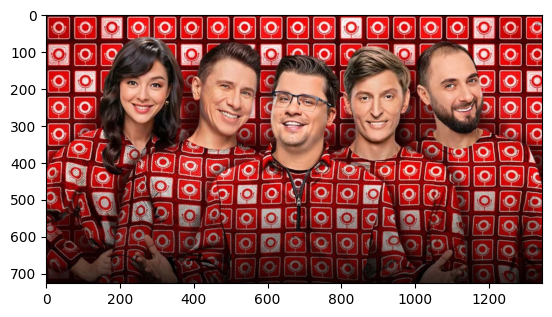

In [ ]:
image = Image.open(test_pic)
image = np.array(image)
plt.imshow(image)

In [ ]:
# Подгружаем предобученный детектор на основе YOLO
face_detector = FaceDetector()
result = face_detector.predict(test_pic)


image 1/1 /content/test_pic.jpg: 352x640 5 faces, 49.0ms
Speed: 8.0ms preprocess, 49.0ms inference, 34.3ms postprocess per image at shape (1, 3, 352, 640)
Results saved to /content/runs/detect/predict


In [ ]:
# Создадим массив с обнаруженными лицам на тестовой картинке:
faces = []
for box in result[0].boxes:
    faces.append(Image.fromarray(np.array(transforms.functional.crop(Image.fromarray(image), int(box.xyxy[0][1]), int(box.xyxy[0][0]), int(box.xywh[0][3]), int(box.xywh[0][2])))))

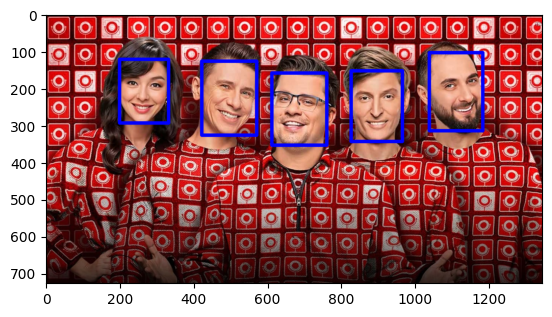

In [ ]:
# Посмотрим на сдетектированные лица
for box in result[0].boxes:
    p1, p2 = (int(box.xyxy[0][0]), int(box.xyxy[0][1])), (int(box.xyxy[0][2]) , int(box.xyxy[0][3]))
    cv2.rectangle(image, p1, p2, color=(0, 0, 255), thickness=8, lineType=cv2.LINE_AA)

plt.imshow(image)

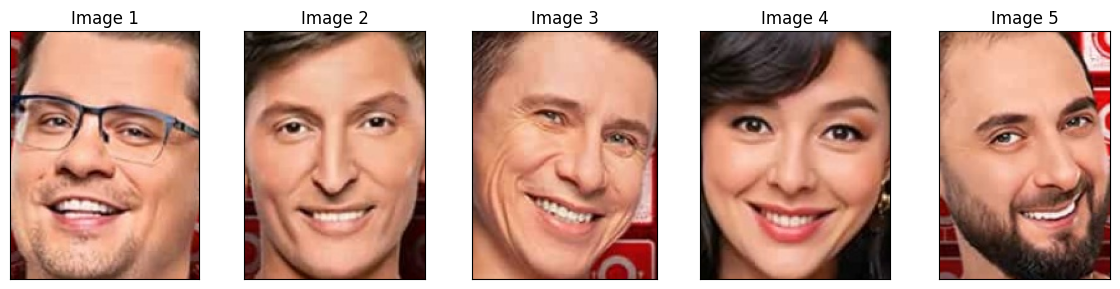

In [ ]:
# Посмотрим на вырезанные лица
ncols = len(faces)
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = np.array(faces[ix])
    ax.imshow(img)
    ax.set_title(f"Image {ix + 1}")
    ax.set_xticks([])
    ax.set_yticks([])

# 3. Aligning

Готовим трансформации для нашей обученной модели:

In [ ]:
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((256, 256)),
    v2.Normalize(mean=[0., 0., 0.],
                    std=[1., 1., 1.]),
])

Создадим батч картинок из обнаруженных лиц:

In [ ]:
image_batch = None
for face in faces:
    face = transform(face).unsqueeze(0)
    if image_batch is not None:
        image_batch = torch.vstack([image_batch, face])
    else:
        image_batch = face

In [ ]:
# Проверка формы
image_batch.shape

torch.Size([5, 3, 256, 256])

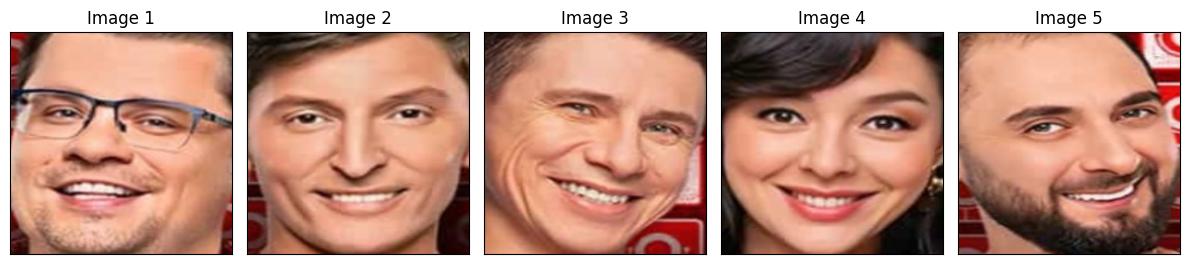

In [ ]:
# Выведем трансформированные лица:
ncols = image_batch.shape[0]
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = np.array(image_batch[ix])

    image = image_batch[ix]
    img = np.array(image)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))

    ax.imshow(img)
    ax.set_title(f"Image {ix + 1}")
    ax.set_xticks([])
    ax.set_yticks([])

Применим нашу модель, чтобы найти ключевые точки на лице:

In [ ]:
shn_model = StackedHourglassNetwork(in_channels=3, num_stacks=4, num_blocks=1, num_heatmaps=5, hourglass_depth=4)
shn_model.to(DEVICE)
shn_model.load_state_dict(torch.load("./models/SHN_stack4_hg4_epoch30.weights", weights_only=True, map_location=torch.device('cpu')))
shn_model.eval()

StackedHourglassNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res1): ResidualBlock(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (res2): ResidualBlock(
    (skip): Identity()
    (conv1): Conv2d(128, 64, kern

In [ ]:
preds = shn_model(image_batch.to(DEVICE))[-1]
preds = preds.detach().cpu()

image_w_landmarks = image_batch.clone()

lm = []
for p in preds:
    lm.append(convert_heatmap2landmark(p))

Посмотрим как получилось найти точки:

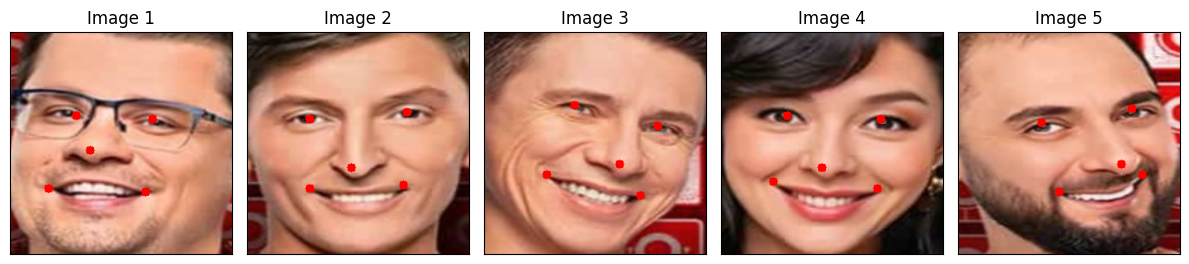

In [ ]:
ncols = image_batch.shape[0]
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = np.array(image_batch[ix])

    image = image_batch[ix]
    img = np.array(image)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()

    landmark = tuple([list(map(round, xy_coord)) for xy_coord in lm[ix]])
    for i in range(5):
        x_c, y_c = landmark[i]
        cv2.circle(img, (x_c, y_c), 5, (255, 0, 0), -1)

    ax.imshow(img)
    ax.set_title(f"Image {ix + 1}")
    ax.set_xticks([])
    ax.set_yticks([])

Точки определились достаточно хорошо. Теперь выравним картинки на основе этих точек.

/tmp/ipython-input-1188567710.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  face_aligned = transform(Image.fromarray((aligned_face * 255).astype('uint8'), 'RGB')).unsqueeze(0)


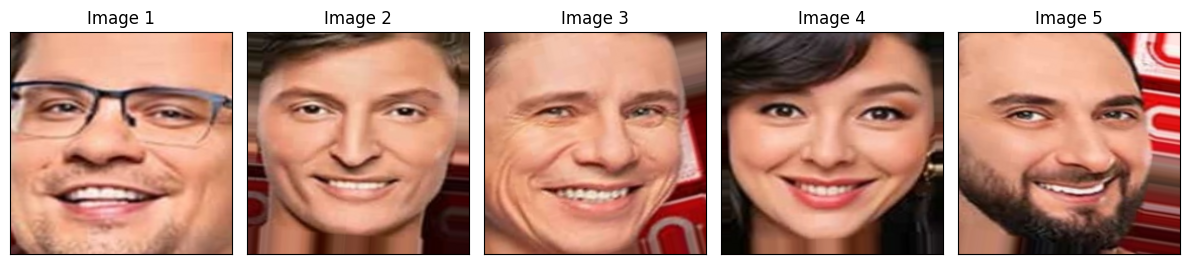

In [ ]:
image_batch_aligned = None
ncols = image_batch.shape[0]
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = image_batch[ix]
    img = np.array(img)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()

    aligned_face, _, _, _ = face_aligner(img, lm[ix])

    ax.imshow(aligned_face)
    ax.set_title(f"Image {ix + 1}")
    ax.set_xticks([])
    ax.set_yticks([])

    face_aligned = transform(Image.fromarray((aligned_face * 255).astype('uint8'), 'RGB')).unsqueeze(0)
    if image_batch_aligned is not None:
        image_batch_aligned = torch.vstack([image_batch_aligned, face_aligned])
    else:
        image_batch_aligned = face_aligned

# 4. Recognizing

Подгружаем нашу модель по распознаванию лиц:

In [ ]:
fr_arc = FaceRecorgnizer(model_name="efficientnet_b3", loss_class=ArcFaceLoss, feat_dim=512).to(DEVICE)
fr_arc.load_state_dict(torch.load("./models/model_FR_ArcFaceLoss_0.7500_epoch_50_B3.weights", weights_only=True, map_location=torch.device('cpu')))
fr_arc.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

FaceRecorgnizer(
  (backbone): Backbone(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (bn1): BatchNormAct2d(
              40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(10, 40, kernel_size=(1, 1),

Используем батч выровненных в прошлом разделе лиц и предсказываем эмбеддинги лиц, размерностью [512]:

In [ ]:
features, _ = fr_arc(image_batch_aligned.to(DEVICE), torch.zeros(image_batch_aligned.shape[0], device=DEVICE))

Далее для сравнения загрузим несколько фотографий лиц, которые будем стараться найти среди данной выборки:

In [ ]:
sample_persons = ImageFolder("./sample_persons/", transform=transform)

In [ ]:
faceloader = DataLoader(sample_persons, batch_size=len(sample_persons), shuffle=False)

In [ ]:
samples, labels = next(iter(faceloader))

Посмотрим на эти лица:

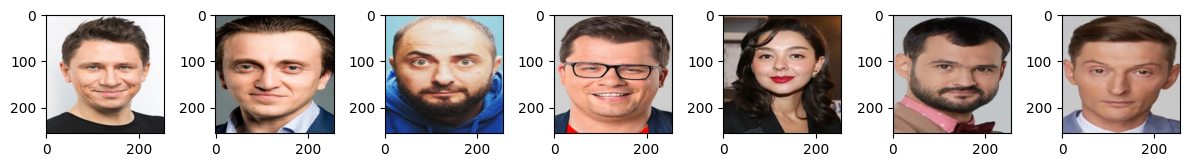

In [ ]:
ncols = samples.shape[0]
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = samples[ix]
    img = np.array(img)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()
    ax.imshow(img)

Выполним предсказание точек и подготовим датасет выравненных лиц:

/tmp/ipython-input-2216169760.py:23: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  sampleface_aligned = transform(Image.fromarray((aligned_face * 255).astype('uint8'), 'RGB')).unsqueeze(0)


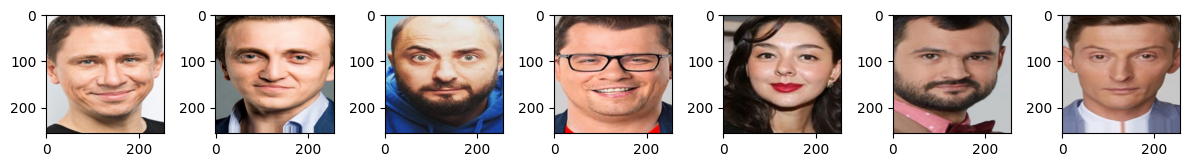

In [ ]:
preds = shn_model(samples.to(DEVICE))[-1]
preds = preds.detach().cpu()

lm = []
for p in preds:
    lm.append(convert_heatmap2landmark(p))

samples_aligned = None
ncols = samples.shape[0]
nrows = 1
_, axes = plt.subplots(nrows, ncols, figsize=(12, 3), tight_layout=True)
axes = axes.reshape(-1)
for ix, ax in enumerate(axes):
    img = samples[ix]
    img = np.array(img)
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0)).copy()

    aligned_face, _, _, _ = face_aligner(img, lm[ix])

    ax.imshow(aligned_face)

    sampleface_aligned = transform(Image.fromarray((aligned_face * 255).astype('uint8'), 'RGB')).unsqueeze(0)
    if samples_aligned is not None:
        samples_aligned = torch.vstack([samples_aligned, sampleface_aligned])
    else:
        samples_aligned = sampleface_aligned

Найдём эмбеддинги искомых лиц:

In [ ]:
features_sample, _ = fr_arc(samples_aligned.to(DEVICE), torch.zeros(samples.shape[0], device=DEVICE))

И посмотрим на карту со значениями косинусного сходства для каждой пары лиц:

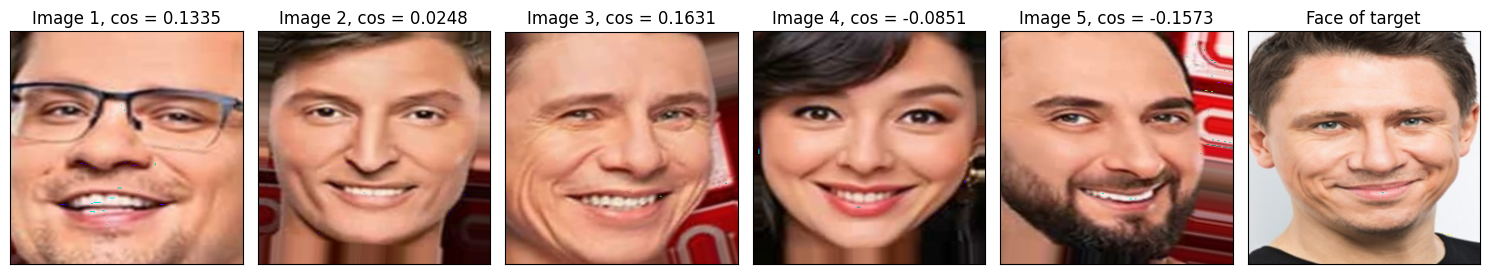

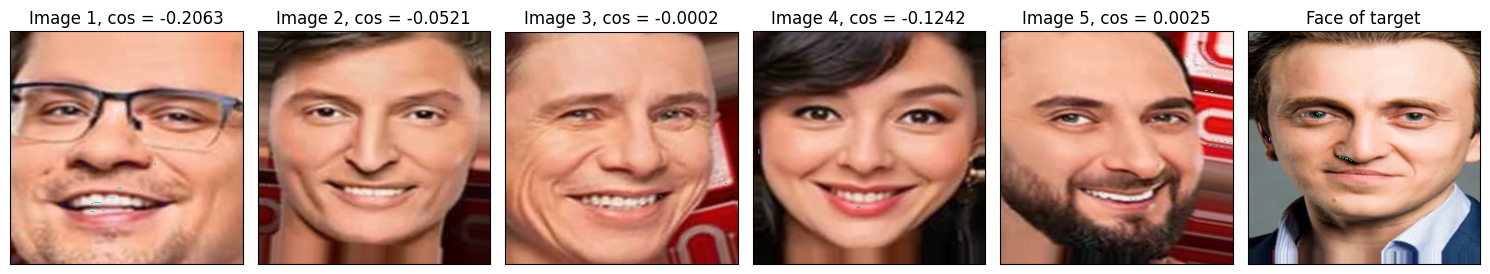

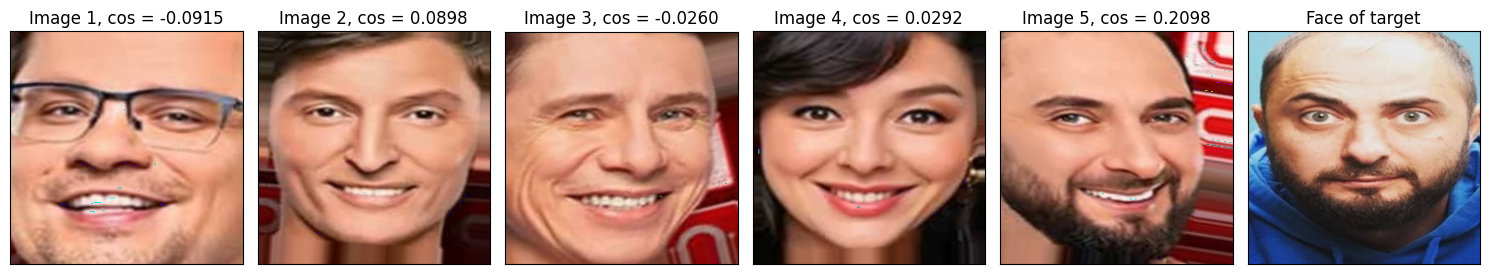

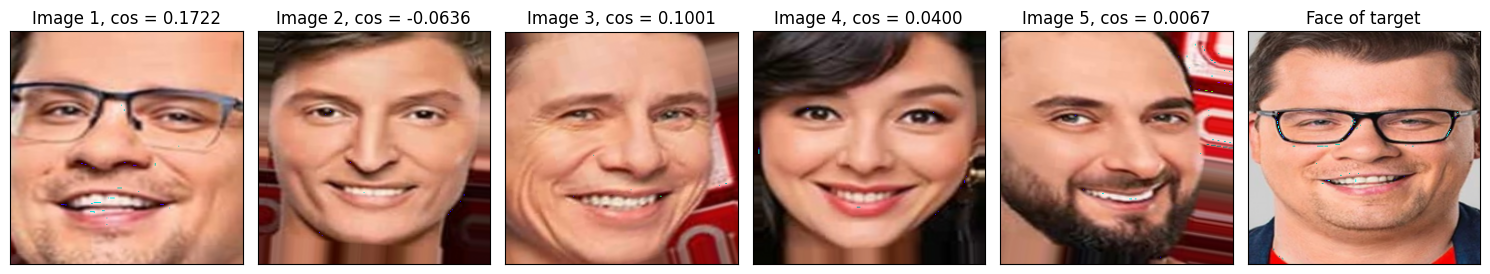

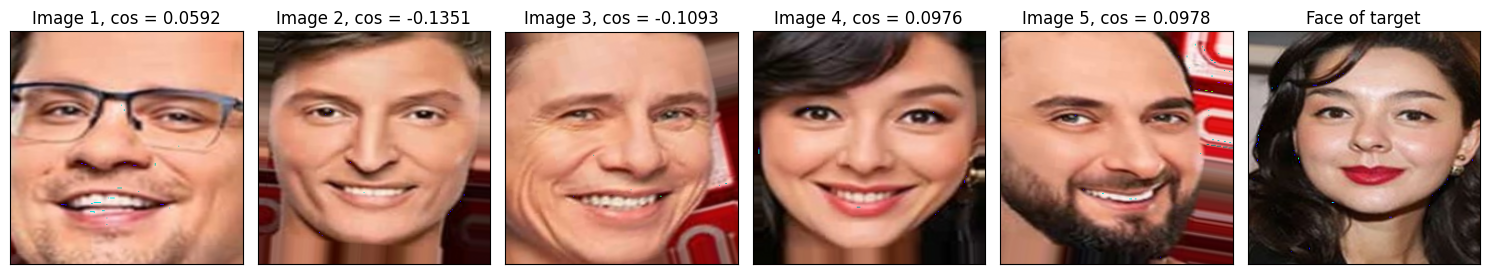

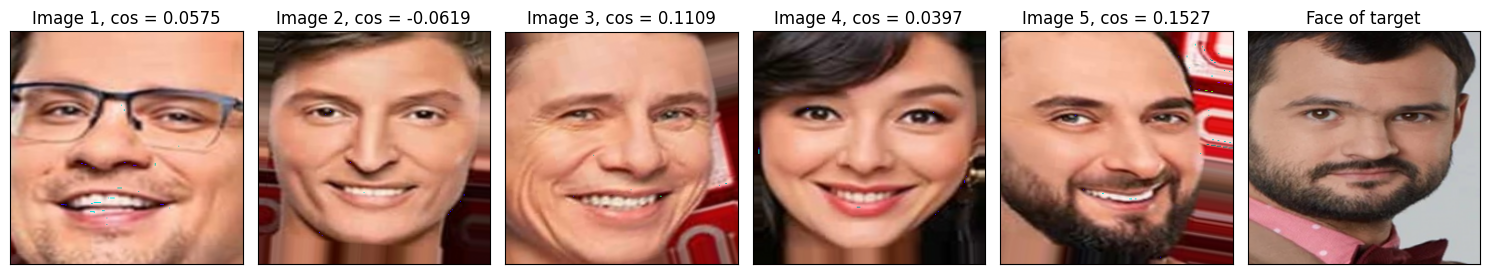

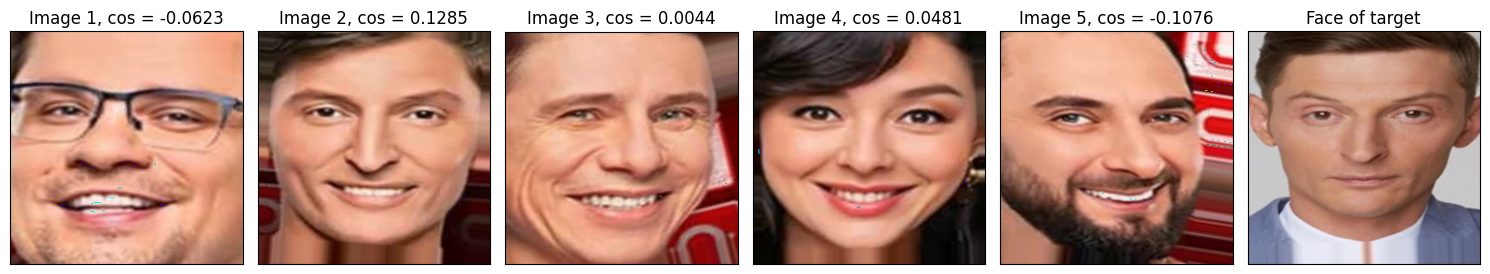

In [ ]:
features = features.detach().cpu()
features_sample = features_sample.detach().cpu()

for idx, feat in enumerate(features_sample):

    ncols = image_batch_aligned.shape[0] + 1
    nrows = 1
    _, axes = plt.subplots(nrows, ncols, figsize=(15, 3), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in enumerate(axes):
        if ix < ncols - 1:
            img = image_batch_aligned[ix]
            img = np.array(img)
            img = np.clip(img, 0, 1)
            img = np.transpose(img, (1, 2, 0)).copy()

            ax.imshow(img)
            cos = F.cosine_similarity(feat, features[ix], dim=0, eps=1e-8)
            ax.set_title(f"Image {ix + 1}, cos = {cos:.4f}")
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            img = samples_aligned[idx]
            img = np.array(img)
            img = np.clip(img, 0, 1)
            img = np.transpose(img, (1, 2, 0)).copy()

            ax.imshow(img)
            ax.set_title(f"Face of target")
            ax.set_xticks([])
            ax.set_yticks([])


## Выводы:

1) Порог определения сходства одного лица к другому предлагаю выбрать косинусное сходство = 0.1.
2) Тогда посмотрим на каждый ряд:
 - 1ый ряд ("Батрутдинов") - модель выберет верное лицо, как максимальное среди порогов > 0.1;
 - 2ой ряд ("Дорохов") - ни одно лицо не имеет сходства большее 0.1, модель отвергнет наличие данного лица в выборке;
 - 3ий ряд ("Карабидис") - модель с большой уверенностью (сходство > 0.2) определило верное лицо;
 - 4ый ряд ("Харламов") - модель также верно определило лицо с большим сходством;
 - 5ый рад ("Кравец") - модель ответит, что не нашла подходящего лица, т.к. порог < 0.1. Но правильное лицо имеет метрику немного меньше порога 0.976. Также с порогом 0.978 модель нашла неправильное лицо. Возможно расхождение связано с недостаточным кропом (целевые фотографии не детектились и не кропились, только выравнивались);
 - 6ой ряд ("Скороход") - модель уверенно отвечает, что "Карабидис" это верное лицо. В принципе они действительно похожи - я их тоже путал в их первых сценических зарисовках;
 - 7ой ряд ("Воля") - не сильно больше порога, но модель всё таки справляется и верно определяет целевое лицо.